In [2]:
import numpy as np 
import pandas as pd 
import os, random
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import gc

import os
for dirname, _, filenames in os.walk('/kaggle/input/statml'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/statml/train_B.npz
/kaggle/input/statml/test.npz
/kaggle/input/statml/train_A.npz


In [3]:
import pickle
data_dir = "/kaggle/input/statml"
data = np.load(os.path.join(data_dir, "train_B.npz"))  
X, y = data["X"], data["y"]
print("Loaded:", X.shape, y.shape)

# encode string labels to ints 
encoder = LabelEncoder()
y = encoder.fit_transform(y)            # e.g. Boot→0, Sandal→1, Shoe→2
#save encoder
with open('/kaggle/working/encoder_trainB.pkl', 'wb') as f:
    pickle.dump(encoder, f)
print("Label mapping:", dict(zip(encoder.classes_,
                                 range(len(encoder.classes_)))))

# normalise images 
X = X.astype("float32") / 255.0

# flatten 
X_feat = X.reshape(len(X), -1)
print("Final features (flattened only):", X_feat.shape)

Loaded: (12000, 224, 224, 3) (12000,)
Label mapping: {'Boot': 0, 'Sandal': 1, 'Shoe': 2}
Final features (flattened only): (12000, 150528)


In [4]:
def make_folds(n, k=10, seed=42, y=None):
    """
    Create stratified k-fold splits that preserve class distribution.
    
    Parameters:
    - n: Total number of samples
    - k: Number of folds (default=10)
    - seed: Random seed for reproducibility (default=42)
    - y: Labels for stratification (required)
    
    Returns:
    - List of k arrays containing indices for each fold
    """
    np.random.seed(seed)
    
    unique_classes = np.unique(y)
    folds = [[] for _ in range(k)]
    
    # For each class, split its samples across k folds
    for cls in unique_classes:
        cls_indices = np.where(y == cls)[0]
        np.random.shuffle(cls_indices)
        cls_splits = np.array_split(cls_indices, k)
        
        # Add class samples to each fold
        for fold_idx, split in enumerate(cls_splits):
            folds[fold_idx].extend(split)
    
    # Shuffle within each fold and convert to numpy arrays
    for i in range(k):
        np.random.shuffle(folds[i])
        folds[i] = np.array(folds[i])
    
    return folds

In [5]:
def confusion_matrix_manual(y_true, y_pred, labels):
    n = len(labels)
    label_to_idx = {lab: i for i, lab in enumerate(labels)}
    cm = np.zeros((n, n), dtype=int)
    for yt, yp in zip(y_true, y_pred):
        i = label_to_idx[yt]
        j = label_to_idx[yp]
        cm[i, j] += 1
    return cm

In [6]:
def calc_metrics(cm):
    TP = np.diag(cm)
    FP = cm.sum(0) - TP
    FN = cm.sum(1) - TP
    precision = np.mean(TP / (TP + FP + 1e-9))
    recall    = np.mean(TP / (TP + FN + 1e-9))
    f1 = 2 * precision * recall / (precision + recall + 1e-9)
    acc = TP.sum() / cm.sum()
    return acc, precision, recall, f1

In [7]:
# Random Forest builder 
from sklearn.ensemble import RandomForestClassifier

def rf_model_builder(
    n_estimators=100,
    max_depth=None,
    max_features="log2",
    min_samples_leaf=5,
    max_samples=0.8,
    random_state=42
):
   
    return RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        max_features=max_features,
        min_samples_leaf=min_samples_leaf,
        class_weight="balanced_subsample",
        n_jobs=-1,
        random_state=random_state,
        bootstrap=True,
        oob_score=False,
        max_samples=max_samples,
        verbose=0
    )

In [8]:
# Train one fold for RF 
def train_one_fold_rf(X_train, y_train, X_val, y_val, model_builder, **params):
    model = model_builder(**params)
    model.fit(X_train, y_train)
    preds = model.predict(X_val)
    return model, preds

In [9]:
# Nested CV for RF (tuning only n_estimators; returns ne_mode) 
from collections import Counter
import numpy as np

def evaluate_model_nested_cv_rf(
    X, y, model_builder,
    cand_n_estimators=(200,600,800,1000),
    fixed_max_features="log2",
    fixed_max_depth=None,
    min_samples_leaf=5, max_samples=0.8,
    k_outer=10, k_inner=3, seed=42
):
    folds = make_folds(len(X), k_outer, seed=seed, y=y)
    metrics_all = []
    chosen_params = []   # best n_estimators per outer fold

    grid = list(cand_n_estimators)

    for i in range(k_outer):
        print(f"\n=== Outer Fold {i+1}/{k_outer} ===")
        test_idx  = folds[i]
        train_idx = np.concatenate([folds[j] for j in range(k_outer) if j != i])
        X_train, y_train = X[train_idx], y[train_idx]
        X_test,  y_test  = X[test_idx],  y[test_idx]

        # inner folds for tuning
        inner_folds = make_folds(len(X_train), k_inner, seed=seed, y=y_train)
        mean_accs = []

        for ne in grid:
            inner_scores = []
            for j in range(k_inner):
                val_idx = inner_folds[j]
                tr_idx  = np.concatenate([inner_folds[m] for m in range(k_inner) if m != j])

                _, y_pred_val = train_one_fold_rf(
                    X_train[tr_idx], y_train[tr_idx],
                    X_train[val_idx], y_train[val_idx],
                    model_builder=model_builder,
                    n_estimators=ne,
                    max_depth=fixed_max_depth,
                    max_features=fixed_max_features,
                    min_samples_leaf=min_samples_leaf,
                    max_samples=max_samples,
                    random_state=seed
                )

                cm = confusion_matrix_manual(y_train[val_idx], y_pred_val, labels=np.unique(y))
                acc, _, _, _ = calc_metrics(cm)
                inner_scores.append(acc)

            mean_accs.append(np.mean(inner_scores))

        best_idx = int(np.argmax(mean_accs))
        best_ne = grid[best_idx]
        chosen_params.append(best_ne)
        print(f"Best param → n_estimators={best_ne}")

        # train on full inner-train and evaluate on outer test
        model, y_pred = train_one_fold_rf(
            X_train, y_train, X_test, y_test,
            model_builder=model_builder,
            n_estimators=best_ne,
            max_depth=fixed_max_depth,
            max_features=fixed_max_features,
            min_samples_leaf=min_samples_leaf,
            max_samples=max_samples,
            random_state=seed
        )
        cm = confusion_matrix_manual(y_test, y_pred, labels=np.unique(y))
        acc, prec, rec, f1 = calc_metrics(cm)
        metrics_all.append([acc, prec, rec, f1])
        print(f"Fold {i+1}: Acc={acc:.3f}, P={prec:.3f}, R={rec:.3f}, F1={f1:.3f}")

    metrics_all = np.array(metrics_all)
    mean, std = metrics_all.mean(0), metrics_all.std(0)

    print("\n=== Random Forest Nested CV Results ===")
    print(f"Accuracy : {mean[0]:.3f} ± {std[0]:.3f}")
    print(f"Precision: {mean[1]:.3f} ± {std[1]:.3f}")
    print(f"Recall   : {mean[2]:.3f} ± {std[2]:.3f}")
    print(f"F1-score : {mean[3]:.3f} ± {std[3]:.3f}")

    # mode of n_estimators across outer folds
    ne_mode = Counter(chosen_params).most_common(1)[0][0]
    print("\nMost-selected param across outer folds:")
    print(f"n_estimators mode: {ne_mode}")

 
    return ne_mode, mean, std, chosen_params

In [10]:
print("\n### Evaluating Random Forest ###")
best_ne, mean_B, std_B, chosen_params = evaluate_model_nested_cv_rf(
    X_feat, y,
    model_builder=rf_model_builder,          
    cand_n_estimators=(200,600,800,1000),
    fixed_max_features="log2",
    fixed_max_depth=None,                    
    min_samples_leaf=5,
    max_samples=0.8,
    k_outer=10, k_inner=3, seed=42
)
print("Best n_estimators (mode across folds):", best_ne)


### Evaluating Random Forest ###

=== Outer Fold 1/10 ===
Best param → n_estimators=800
Fold 1: Acc=0.821, P=0.820, R=0.821, F1=0.820

=== Outer Fold 2/10 ===
Best param → n_estimators=800
Fold 2: Acc=0.799, P=0.800, R=0.799, F1=0.799

=== Outer Fold 3/10 ===
Best param → n_estimators=800
Fold 3: Acc=0.823, P=0.822, R=0.823, F1=0.823

=== Outer Fold 4/10 ===
Best param → n_estimators=800
Fold 4: Acc=0.817, P=0.818, R=0.817, F1=0.818

=== Outer Fold 5/10 ===
Best param → n_estimators=600
Fold 5: Acc=0.815, P=0.816, R=0.815, F1=0.816

=== Outer Fold 6/10 ===
Best param → n_estimators=1000
Fold 7: Acc=0.838, P=0.838, R=0.837, F1=0.838

=== Outer Fold 8/10 ===
Best param → n_estimators=600
Fold 8: Acc=0.797, P=0.796, R=0.797, F1=0.796

=== Outer Fold 9/10 ===
Best param → n_estimators=1000
Fold 9: Acc=0.811, P=0.813, R=0.811, F1=0.812

=== Outer Fold 10/10 ===
Best param → n_estimators=800
Fold 10: Acc=0.816, P=0.815, R=0.816, F1=0.816

=== Random Forest Nested CV Results ===
Accuracy : 0

In [11]:
#  Save CV summary 
cv_results_B = {
    'mean': mean_B,
    'std': std_B,
    'accuracy': float(mean_B[0]),
    'precision': float(mean_B[1]),
    'recall': float(mean_B[2]),
    'f1': float(mean_B[3]),
    'modes': {
        'n_estimators': best_ne,
    },
    'chosen_params_per_outer_fold': chosen_params
}
with open('/kaggle/working/rf_cv_results_trainB.pkl', 'wb') as f:
    pickle.dump(cv_results_B, f)
print("CV results saved!  (→ /kaggle/working/rf_cv_results_trainB.pkl)")

CV results saved!  (→ /kaggle/working/rf_cv_results_trainB.pkl)


In [12]:
# Train Final RF on full Train_B 
print("\n=== Training Final Random Forest on Full Train_B ===")
final_rf_B = rf_model_builder(n_estimators=best_ne, random_state=42)
final_rf_B.fit(X_feat, y)

# Save final model + label encoder 
import joblib
joblib.dump({
    "rf": final_rf_B,
    "label_encoder": encoder
}, '/kaggle/working/rf_final_B_bundle.pkl')
print("Saved bundle: /kaggle/working/rf_final_B_bundle.pkl")


=== Training Final Random Forest on Full Train_B ===
Saved bundle: /kaggle/working/rf_final_B_bundle.pkl


In [13]:
# Test-time preprocessing (match train: normalise + flatten only)
test_data = np.load(os.path.join(data_dir, "test.npz"))
X_test, y_test_raw = test_data["X"], test_data["y"]
y_test = encoder.transform(y_test_raw)

X_test = X_test.astype("float32") / 255.0
X_test_feat = X_test.reshape(len(X_test), -1)

# Predict + metrics 
y_pred_test = final_rf_B.predict(X_test_feat)
labels = np.arange(len(encoder.classes_))
cm_test = confusion_matrix_manual(y_test, y_pred_test, labels=np.unique(y_test))
acc_test, prec_test, rec_test, f1_test = calc_metrics(cm_test)

print(f"\n=== Test Set Results ===")
print(f"Accuracy : {acc_test:.3f}")
print(f"Precision: {prec_test:.3f}")
print(f"Recall   : {rec_test:.3f}")
print(f"F1-score : {f1_test:.3f}")

print(f"\nConfusion Matrix:")
print(cm_test)
print(f"Classes: {encoder.classes_}")

# ===== COMPARISON WITH CV =====
with open('/kaggle/working/rf_cv_results_trainB.pkl', 'rb') as f:
    cv_results_B = pickle.load(f)


rf_mean_B = cv_results_B['mean']
rf_std_B = cv_results_B['std']

print(f"\n=== Performance Comparison ===")
print(f"CV Performance:   {rf_mean_B[0]:.3f} ± {rf_std_B[0]:.3f}") 
print(f"Test Performance: {acc_test:.3f}")
print(f"Difference:       {acc_test - rf_mean_B[0]:.3f}")  


=== Test Set Results ===
Accuracy : 0.811
Precision: 0.810
Recall   : 0.811
F1-score : 0.810

Confusion Matrix:
[[900  59  41]
 [ 84 736 180]
 [ 45 158 797]]
Classes: ['Boot' 'Sandal' 'Shoe']

=== Performance Comparison ===
CV Performance:   0.816 ± 0.011
Test Performance: 0.811
Difference:       -0.005


****Repeating the above, but this time using train_A (which is the image set with only clean images)****

In [20]:
data_dir = "/kaggle/input/statml"
data = np.load(os.path.join(data_dir, "train_A.npz"))  
X, y = data["X"], data["y"]
print("Loaded:", X.shape, y.shape)

# encode string labels to ints
encoder = LabelEncoder()
y = encoder.fit_transform(y)            # e.g. Boot→0, Sandal→1, Shoe→2
#save encoder
with open('/kaggle/working/encoder_trainA.pkl', 'wb') as f:
    pickle.dump(encoder, f)
print("Label mapping:", dict(zip(encoder.classes_,
                                 range(len(encoder.classes_)))))

# normalise images
X = X.astype("float32") / 255.0

# flatten 
X_feat = X.reshape(len(X), -1)
print("Final features (flattened only):", X_feat.shape)

Loaded: (12000, 224, 224, 3) (12000,)
Label mapping: {'Boot': 0, 'Sandal': 1, 'Shoe': 2}
Final features (flattened only): (12000, 150528)


In [21]:
print("\n### Evaluating Random Forest  ###")
best_ne, mean_A, std_A, chosen_params = evaluate_model_nested_cv_rf(
    X_feat, y,
    model_builder=rf_model_builder,          
    cand_n_estimators=(200,600,800,1000),
    fixed_max_features="log2",
    fixed_max_depth=None,                  
    min_samples_leaf=5,
    max_samples=0.8,
    k_outer=10, k_inner=3, seed=42
)
print("Best n_estimators (mode across folds):", best_ne)


### Evaluating Random Forest  ###

=== Outer Fold 1/10 ===
Best param → n_estimators=800
Fold 1: Acc=0.935, P=0.937, R=0.935, F1=0.936

=== Outer Fold 2/10 ===
Best param → n_estimators=1000
Fold 2: Acc=0.941, P=0.944, R=0.941, F1=0.942

=== Outer Fold 3/10 ===
Best param → n_estimators=600
Fold 3: Acc=0.925, P=0.926, R=0.925, F1=0.926

=== Outer Fold 4/10 ===
Best param → n_estimators=200
Fold 4: Acc=0.930, P=0.931, R=0.930, F1=0.931

=== Outer Fold 5/10 ===
Best param → n_estimators=800
Fold 5: Acc=0.925, P=0.926, R=0.925, F1=0.925

=== Outer Fold 6/10 ===
Best param → n_estimators=1000
Fold 6: Acc=0.945, P=0.947, R=0.945, F1=0.946

=== Outer Fold 7/10 ===
Best param → n_estimators=600
Fold 7: Acc=0.931, P=0.933, R=0.931, F1=0.932

=== Outer Fold 8/10 ===
Best param → n_estimators=600
Fold 8: Acc=0.927, P=0.928, R=0.927, F1=0.927

=== Outer Fold 9/10 ===
Best param → n_estimators=800
Fold 9: Acc=0.928, P=0.929, R=0.928, F1=0.929

=== Outer Fold 10/10 ===
Best param → n_estimators=80

In [22]:
# Save CV summary 
import pickle
cv_results_A = {
    'mean': mean_A,
    'std': std_A,
    'accuracy': float(mean_A[0]),
    'precision': float(mean_A[1]),
    'recall': float(mean_A[2]),
    'f1': float(mean_A[3]),
    'modes': {
        'n_estimators': best_ne,
    },
    'chosen_params_per_outer_fold': chosen_params
}
with open('/kaggle/working/rf_cv_results_trainA.pkl', 'wb') as f:
    pickle.dump(cv_results_A, f)
print("CV results saved!  (→ /kaggle/working/rf_cv_results_trainA.pkl)")

CV results saved!  (→ /kaggle/working/rf_cv_results_trainA.pkl)


In [24]:
# Train Final RF on full Train_A 
print("\n=== Training Final Random Forest on Full Train_A ===")
final_rf_A = rf_model_builder(n_estimators=best_ne, random_state=42)
final_rf_A.fit(X_feat, y)

# Save final model + label encoder 
import joblib
joblib.dump({
    "rf": final_rf_A,
    "label_encoder": encoder
}, '/kaggle/working/rf_final_A_bundle.pkl')
print("Saved bundle: /kaggle/working/rf_final_A_bundle.pkl")


=== Training Final Random Forest on Full Train_A ===
Saved bundle: /kaggle/working/rf_final_A_bundle.pkl


In [25]:
#Test-time preprocessing (match train: normalise + flatten only)
test_data = np.load(os.path.join(data_dir, "test.npz"))
X_test, y_test_raw = test_data["X"], test_data["y"]
y_test = encoder.transform(y_test_raw)

X_test = X_test.astype("float32") / 255.0
X_test_feat = X_test.reshape(len(X_test), -1)

# Predict + metrics 
y_pred_test = final_rf_A.predict(X_test_feat)
labels = np.arange(len(encoder.classes_))
cm_test = confusion_matrix_manual(y_test, y_pred_test, labels=np.unique(y_test))
acc_test, prec_test, rec_test, f1_test = calc_metrics(cm_test)

print(f"\n=== Test Set Results ===")
print(f"Accuracy : {acc_test:.3f}")
print(f"Precision: {prec_test:.3f}")
print(f"Recall   : {rec_test:.3f}")
print(f"F1-score : {f1_test:.3f}")

print(f"\nConfusion Matrix:")
print(cm_test)
print(f"Classes: {encoder.classes_}")

# ===== COMPARISON WITH CV =====
with open('/kaggle/working/rf_cv_results_trainA.pkl', 'rb') as f:
    cv_results_A = pickle.load(f)


rf_mean_A = cv_results_A['mean']
rf_std_A = cv_results_A['std']

print(f"\n=== Performance Comparison ===")
print(f"CV Performance:   {rf_mean_A[0]:.3f} ± {rf_std_A[0]:.3f}") 
print(f"Test Performance: {acc_test:.3f}")
print(f"Difference:       {acc_test - rf_mean_A[0]:.3f}")  


=== Test Set Results ===
Accuracy : 0.645
Precision: 0.709
Recall   : 0.645
F1-score : 0.676

Confusion Matrix:
[[512 143 345]
 [ 45 523 432]
 [ 18  81 901]]
Classes: ['Boot' 'Sandal' 'Shoe']

=== Performance Comparison ===
CV Performance:   0.931 ± 0.007
Test Performance: 0.645
Difference:       -0.286


**Bootstrapping, to get error bars**

In [14]:
#bootstrapping to get error bars for test metrics
#INPUTS:
#y_true - true labels of test set
#y_pred - predicted labels of test set
#n_bootstrap - number of bootstrap iterations to perform
#confidence - to calculate confidence interval, to determine statistical significance
def bootstrap_metrics(y_true, y_pred, n_bootstrap=1000, confidence=0.95):
    n_samples = len(y_true)
    results = {"acc": [], "prec": [], "rec": [], "f1": []}
    labels = np.unique(y_true)

    for _ in range(n_bootstrap):
        idx = np.random.choice(n_samples, n_samples, replace=True)
        y_t, y_p = y_true[idx], y_pred[idx]
        cm = confusion_matrix_manual(y_t, y_p, labels=labels)
        acc, prec, rec, f1 = calc_metrics(cm)
        results["acc"].append(acc)
        results["prec"].append(prec)
        results["rec"].append(rec)
        results["f1"].append(f1)

    alpha = (1 - confidence) / 2
    stats = {}
    for k, v in results.items():
        v = np.array(v)
        stats[k] = (
            np.mean(v),
            np.percentile(v, 100 * alpha),
            np.percentile(v, 100 * (1 - alpha)),
        )
    return stats

In [26]:
#bootstrap for train A
print("\n=== Bootstrap Analysis for Train_A Model ===")

stats_A = bootstrap_metrics(y_test, y_pred_test, n_bootstrap=1000)

#extract metrics
mean_acc_A, lower_acc_A, upper_acc_A = stats_A['acc']
mean_prec_A, lower_prec_A, upper_prec_A = stats_A['prec']
mean_rec_A, lower_rec_A, upper_rec_A = stats_A['rec']
mean_f1_A, lower_f1_A, upper_f1_A = stats_A['f1']

print(f"Test Accuracy:  {mean_acc_A:.4f} ({lower_acc_A:.4f}, {upper_acc_A:.4f})")
print(f"Test Precision: {mean_prec_A:.4f} ({lower_prec_A:.4f}, {upper_prec_A:.4f})")
print(f"Test Recall:    {mean_rec_A:.4f} ({lower_rec_A:.4f}, {upper_rec_A:.4f})")
print(f"Test F1:        {mean_f1_A:.4f} ({lower_f1_A:.4f}, {upper_f1_A:.4f})")


=== Bootstrap Analysis for Train_A Model ===
Test Accuracy:  0.6453 (0.6280, 0.6620)
Test Precision: 0.7089 (0.6930, 0.7254)
Test Recall:    0.6453 (0.6300, 0.6603)
Test F1:        0.6756 (0.6600, 0.6909)


In [19]:
#bootstrap for train B
print("\n=== Bootstrap Analysis for Train_B Model ===")

# Load test data
test_data_B = np.load(os.path.join(data_dir, "test.npz"))
X_test_raw, y_test_raw_B = test_data_B["X"], test_data_B["y"]

# Load Train_B encoder and encode labels
with open('/kaggle/working/encoder_trainB.pkl', 'rb') as f:
    encoder_B = pickle.load(f)
y_test_B = encoder_B.transform(y_test_raw_B).astype("int64")

#preprocess images
X_test_B = X_test_raw.astype("float32") / 255.0
X_test_B_feat = X_test_B.reshape(len(X_test_B), -1)
y_test_B = y_test_B.astype("int64")

bundle_path_B = '/kaggle/working/rf_final_B_bundle.pkl'
model_B = None
if os.path.exists(bundle_path_B):
    bundle_B = joblib.load(bundle_path_B)
    model_B = bundle_B["rf"]
else:
    # Fallback: plain joblib model file
    model_B = joblib.load('/kaggle/working/rf_final_B.joblib')

# Get predictions (RF)
y_pred_test_B = model_B.predict(X_test_B_feat)


#bootstrap for Train_B
stats_B = bootstrap_metrics(y_test_B, y_pred_test_B, n_bootstrap=1000)

# Extract metrics
mean_acc_B, lower_acc_B, upper_acc_B = stats_B['acc']
mean_prec_B, lower_prec_B, upper_prec_B = stats_B['prec']
mean_rec_B, lower_rec_B, upper_rec_B = stats_B['rec']
mean_f1_B, lower_f1_B, upper_f1_B = stats_B['f1']

print(f"Test Accuracy:  {mean_acc_B:.4f} ({lower_acc_B:.4f}, {upper_acc_B:.4f})")
print(f"Test Precision: {mean_prec_B:.4f} ({lower_prec_B:.4f}, {upper_prec_B:.4f})")
print(f"Test Recall:    {mean_rec_B:.4f} ({lower_rec_B:.4f}, {upper_rec_B:.4f})")
print(f"Test F1:        {mean_f1_B:.4f} ({lower_f1_B:.4f}, {upper_f1_B:.4f})")



=== Bootstrap Analysis for Train_B Model ===
Test Accuracy:  0.8109 (0.7970, 0.8240)
Test Precision: 0.8098 (0.7958, 0.8230)
Test Recall:    0.8108 (0.7968, 0.8237)
Test F1:        0.8103 (0.7963, 0.8235)


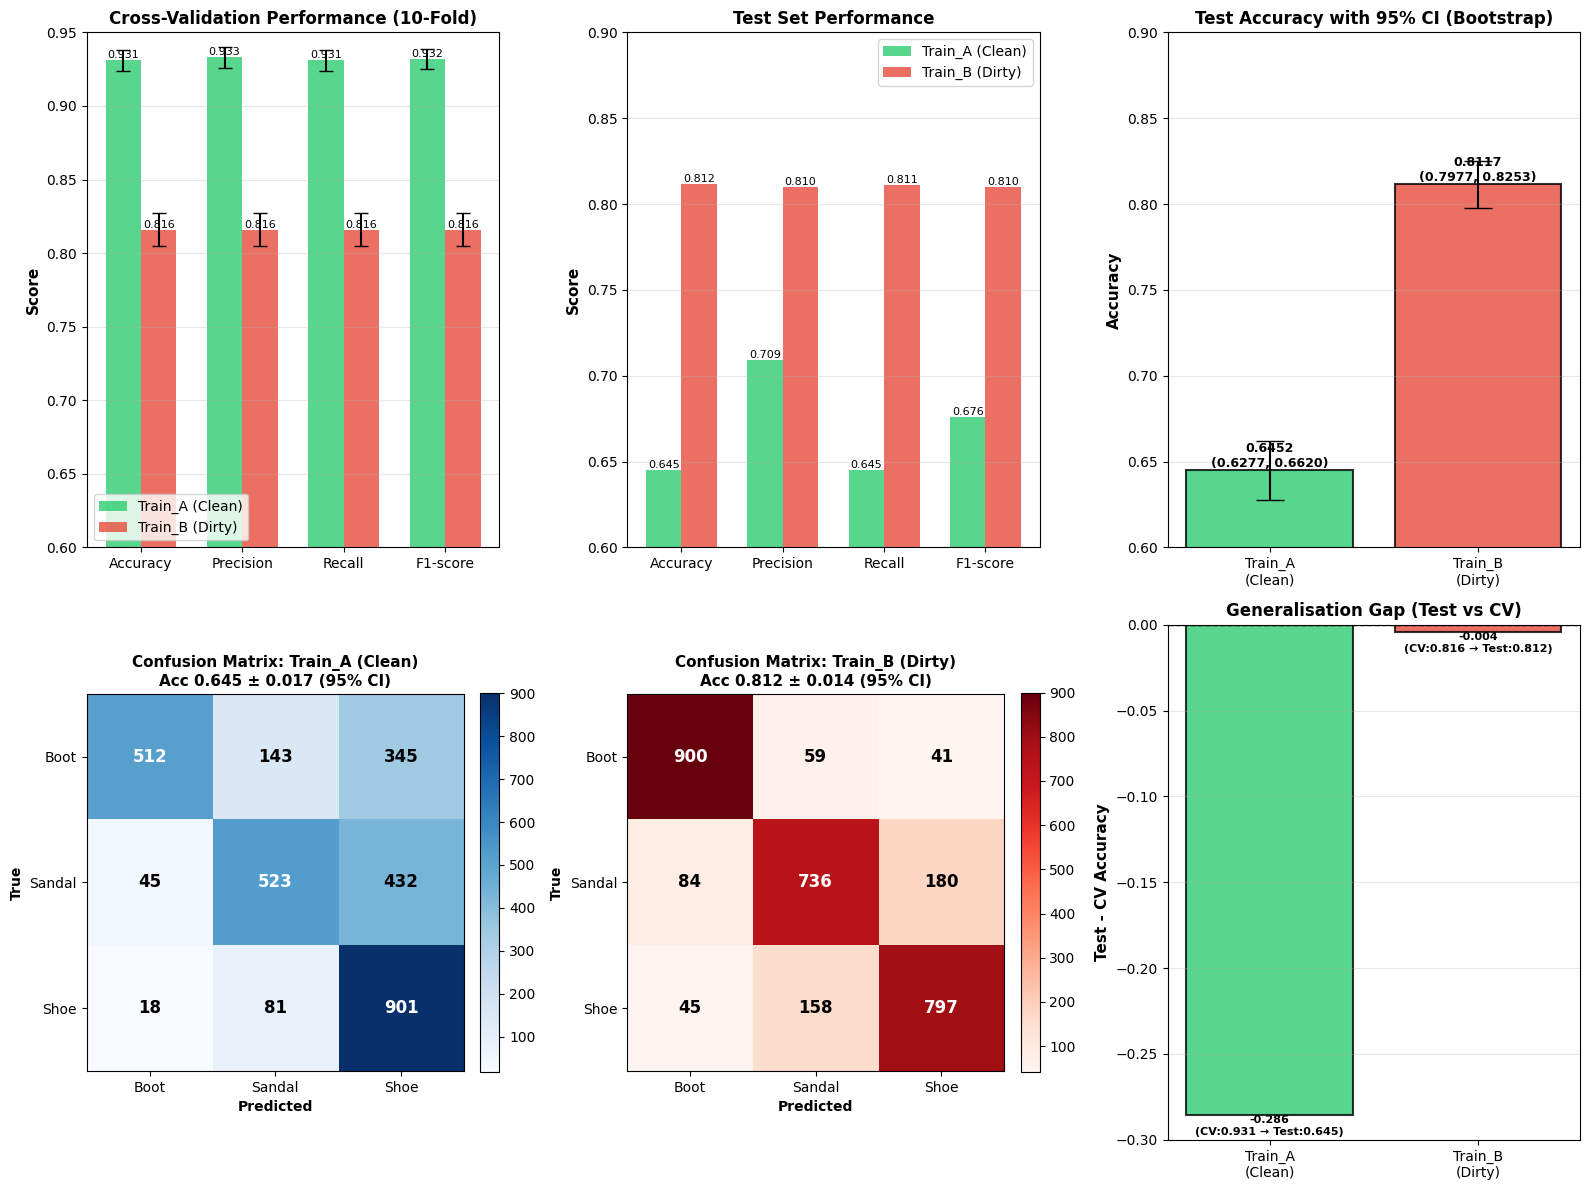

SUMMARY STATISTICS

CROSS-VALIDATION RESULTS (10-Fold):
------------------------------------------------------------
Model                Accuracy        Precision       Recall          F1-Score
Train_A (Clean)      0.931±0.007       0.933±0.007       0.931±0.007       0.932±0.007
Train_B (Dirty)      0.816±0.011       0.816±0.011       0.816±0.011       0.816±0.011

TEST SET RESULTS:
------------------------------------------------------------
Model                Accuracy                       Precision  Recall     F1-Score
Train_A (Clean)      0.6452       (0.6277, 0.6620)       0.709      0.645      0.676
Train_B (Dirty)      0.8117       (0.7977, 0.8253)       0.810      0.811      0.810

KEY FINDINGS:
------------------------------------------------------------
• Train_B (Dirty) outperforms Train_A (Clean) on test by 16.6% (0.6452 → 0.8117).
• Train_A (Clean) shows strong CV→Test drop: 0.931 → 0.645 (gap -0.286).
• Train_B (Dirty) aligns with CV: 0.816 → 0.812 (gap -0.004).
• 95%

In [3]:
# Cross-validation (10-fold) means ± std 
cv_results = {
    'Train_A (Clean)': { 
        'mean': [0.931, 0.933, 0.931, 0.932],
        'std' : [0.007, 0.007, 0.007, 0.007]
    },
    'Train_B (Dirty)': {  
        'mean': [0.816, 0.816, 0.816, 0.816],
        'std' : [0.011, 0.011, 0.011, 0.011]
    }
}

# Test-set metrics + bootstrap 95% CIs
test_results = {
    'Train_A (Clean)': {   # A
        'accuracy': 0.6452,
        'precision': 0.709,
        'recall': 0.645,
        'f1': 0.676,
        'ci_lower': 0.6277,
        'ci_upper': 0.6620
    },
    'Train_B (Dirty)': {   # B
        'accuracy': 0.8117,
        'precision': 0.810,
        'recall': 0.811,
        'f1': 0.810,
        'ci_lower': 0.7977,
        'ci_upper': 0.8253
    }
}

#  Confusion matrices
cm_train_B = np.array([[900,  59,  41],
                       [ 84, 736, 180],
                       [ 45, 158, 797]])  # Train_B (Dirty)

cm_train_A = np.array([[512, 143, 345],
                       [ 45, 523, 432],
                       [ 18,  81, 901]])  # Train_A (Clean)

classes = ['Boot', 'Sandal', 'Shoe']


fig = plt.figure(figsize=(16, 12))
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-score']
x = np.arange(len(metrics))
width = 0.35

# 1) CV Performance Comparison
ax1 = plt.subplot(2, 3, 1)
A_means, A_stds = cv_results['Train_A (Clean)']['mean'], cv_results['Train_A (Clean)']['std']
B_means, B_stds = cv_results['Train_B (Dirty)']['mean'], cv_results['Train_B (Dirty)']['std']

bars1 = ax1.bar(x - width/2, A_means, width, yerr=A_stds, capsize=5,
                label='Train_A (Clean)', alpha=0.8, color='#2ecc71')
bars2 = ax1.bar(x + width/2, B_means, width, yerr=B_stds, capsize=5,
                label='Train_B (Dirty)', alpha=0.8, color='#e74c3c')

ax1.set_ylabel('Score', fontsize=11, fontweight='bold')
ax1.set_title('Cross-Validation Performance (10-Fold)', fontsize=12, fontweight='bold')
ax1.set_xticks(x); ax1.set_xticklabels(metrics)
ax1.legend()
ax1.set_ylim([0.60, 0.95]) 
ax1.grid(axis='y', alpha=0.3)
for bars in (bars1, bars2):
    for b in bars:
        ax1.text(b.get_x() + b.get_width()/2., b.get_height(), f'{b.get_height():.3f}',
                 ha='center', va='bottom', fontsize=8)

# 2) Test Performance Comparison
ax2 = plt.subplot(2, 3, 2)
test_A_vals = [test_results['Train_A (Clean)'][m] for m in ['accuracy','precision','recall','f1']]
test_B_vals = [test_results['Train_B (Dirty)'][m] for m in ['accuracy','precision','recall','f1']]

bars1 = ax2.bar(x - width/2, test_A_vals, width, label='Train_A (Clean)', alpha=0.8, color='#2ecc71')
bars2 = ax2.bar(x + width/2, test_B_vals, width, label='Train_B (Dirty)', alpha=0.8, color='#e74c3c')

ax2.set_ylabel('Score', fontsize=11, fontweight='bold')
ax2.set_title('Test Set Performance', fontsize=12, fontweight='bold')
ax2.set_xticks(x); ax2.set_xticklabels(metrics)
ax2.legend()
ax2.set_ylim([0.60, 0.90])   
ax2.grid(axis='y', alpha=0.3)
for bars in (bars1, bars2):
    for b in bars:
        ax2.text(b.get_x() + b.get_width()/2., b.get_height(), f'{b.get_height():.3f}',
                 ha='center', va='bottom', fontsize=8)

# 3) Test Accuracy with 95% CI
ax3 = plt.subplot(2, 3, 3)
models = ['Train_A\n(Clean)', 'Train_B\n(Dirty)']
accs   = [test_results['Train_A (Clean)']['accuracy'], test_results['Train_B (Dirty)']['accuracy']]
ciL    = [test_results['Train_A (Clean)']['ci_lower'], test_results['Train_B (Dirty)']['ci_lower']]
ciU    = [test_results['Train_A (Clean)']['ci_upper'], test_results['Train_B (Dirty)']['ci_upper']]
errors = [[accs[i] - ciL[i] for i in range(2)], [ciU[i] - accs[i] for i in range(2)]]

bars = ax3.bar(models, accs, yerr=errors, capsize=10, alpha=0.8,
               color=['#2ecc71', '#e74c3c'], edgecolor='black', linewidth=1.5)
ax3.set_ylabel('Accuracy', fontsize=11, fontweight='bold')
ax3.set_title('Test Accuracy with 95% CI (Bootstrap)', fontsize=12, fontweight='bold')
ax3.set_ylim([0.60, 0.90])
ax3.grid(axis='y', alpha=0.3)
for i, b in enumerate(bars):
    ax3.text(b.get_x() + b.get_width()/2., b.get_height(),
             f'{accs[i]:.4f}\n({ciL[i]:.4f}, {ciU[i]:.4f})',
             ha='center', va='bottom', fontsize=9, fontweight='bold')

# 4) Confusion Matrix – Train_A (Clean)
ax4 = plt.subplot(2, 3, 4)
im1 = ax4.imshow(cm_train_A, interpolation='nearest', cmap='Blues')
moe_A = (test_results['Train_A (Clean)']['ci_upper'] - test_results['Train_A (Clean)']['ci_lower'])/2
ax4.set_title(f'Confusion Matrix: Train_A (Clean)\n'
              f'Acc {test_results["Train_A (Clean)"]["accuracy"]:.3f} ± {moe_A:.3f} (95% CI)',
              fontsize=11, fontweight='bold')
ax4.set_xticks(np.arange(len(classes))); ax4.set_yticks(np.arange(len(classes)))
ax4.set_xticklabels(classes); ax4.set_yticklabels(classes)
ax4.set_xlabel('Predicted', fontsize=10, fontweight='bold')
ax4.set_ylabel('True', fontsize=10, fontweight='bold')
for i in range(len(classes)):
    for j in range(len(classes)):
        ax4.text(j, i, cm_train_A[i, j],
                 ha='center', va='center',
                 color='white' if cm_train_A[i, j] > cm_train_A.max()/2 else 'black',
                 fontsize=12, fontweight='bold')
plt.colorbar(im1, ax=ax4, fraction=0.046, pad=0.04)

# 5) Confusion Matrix – Train_B (Dirty)
ax5 = plt.subplot(2, 3, 5)
im2 = ax5.imshow(cm_train_B, interpolation='nearest', cmap='Reds')
moe_B = (test_results['Train_B (Dirty)']['ci_upper'] - test_results['Train_B (Dirty)']['ci_lower'])/2
ax5.set_title(f'Confusion Matrix: Train_B (Dirty)\n'
              f'Acc {test_results["Train_B (Dirty)"]["accuracy"]:.3f} ± {moe_B:.3f} (95% CI)',
              fontsize=11, fontweight='bold')
ax5.set_xticks(np.arange(len(classes))); ax5.set_yticks(np.arange(len(classes)))
ax5.set_xticklabels(classes); ax5.set_yticklabels(classes)
ax5.set_xlabel('Predicted', fontsize=10, fontweight='bold')
ax5.set_ylabel('True', fontsize=10, fontweight='bold')
for i in range(len(classes)):
    for j in range(len(classes)):
        ax5.text(j, i, cm_train_B[i, j],
                 ha='center', va='center',
                 color='white' if cm_train_B[i, j] > cm_train_B.max()/2 else 'black',
                 fontsize=12, fontweight='bold')
plt.colorbar(im2, ax=ax5, fraction=0.046, pad=0.04)

# 6) Generalisation Gap (Test - CV)
ax6 = plt.subplot(2, 3, 6)
cv_accs   = [cv_results['Train_A (Clean)']['mean'][0],
             cv_results['Train_B (Dirty)']['mean'][0]]
test_accs = [test_results['Train_A (Clean)']['accuracy'],
             test_results['Train_B (Dirty)']['accuracy']]
gaps = [test_accs[i] - cv_accs[i] for i in range(2)]
bars = ax6.bar(['Train_A\n(Clean)', 'Train_B\n(Dirty)'], gaps,
               color=['#2ecc71', '#e74c3c'], alpha=0.8, edgecolor='black', linewidth=1.5)
ax6.axhline(0, color='black', linestyle='--', linewidth=1)
ax6.set_ylabel('Test - CV Accuracy', fontsize=11, fontweight='bold')
ax6.set_title('Generalisation Gap (Test vs CV)', fontsize=12, fontweight='bold')
ax6.grid(axis='y', alpha=0.3)
for i, (b, gap, cv_a, te_a) in enumerate(zip(bars, gaps, cv_accs, test_accs)):
    ax6.text(b.get_x() + b.get_width()/2., gap,
             f'{gap:+.3f}\n(CV:{cv_a:.3f} → Test:{te_a:.3f})',
             ha='center', va='bottom' if gap > 0 else 'top',
             fontsize=8, fontweight='bold')

plt.tight_layout()
plt.savefig('rf_results_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# =================
# CONSOLE SUMMARY
# =================
print("=" * 60)
print("SUMMARY STATISTICS")
print("=" * 60)

print("\nCROSS-VALIDATION RESULTS (10-Fold):")
print("-" * 60)
print(f"{'Model':<20} {'Accuracy':<15} {'Precision':<15} {'Recall':<15} {'F1-Score'}")
print(f"Train_A (Clean)      {cv_results['Train_A (Clean)']['mean'][0]:.3f}±{cv_results['Train_A (Clean)']['std'][0]:.3f}       "
      f"{cv_results['Train_A (Clean)']['mean'][1]:.3f}±{cv_results['Train_A (Clean)']['std'][1]:.3f}       "
      f"{cv_results['Train_A (Clean)']['mean'][2]:.3f}±{cv_results['Train_A (Clean)']['std'][2]:.3f}       "
      f"{cv_results['Train_A (Clean)']['mean'][3]:.3f}±{cv_results['Train_A (Clean)']['std'][3]:.3f}")
print(f"Train_B (Dirty)      {cv_results['Train_B (Dirty)']['mean'][0]:.3f}±{cv_results['Train_B (Dirty)']['std'][0]:.3f}       "
      f"{cv_results['Train_B (Dirty)']['mean'][1]:.3f}±{cv_results['Train_B (Dirty)']['std'][1]:.3f}       "
      f"{cv_results['Train_B (Dirty)']['mean'][2]:.3f}±{cv_results['Train_B (Dirty)']['std'][2]:.3f}       "
      f"{cv_results['Train_B (Dirty)']['mean'][3]:.3f}±{cv_results['Train_B (Dirty)']['std'][3]:.3f}")

print("\nTEST SET RESULTS:")
print("-" * 60)
def fmt_ci(k):
    lo, hi = test_results[k]['ci_lower'], test_results[k]['ci_upper']
    return f"({lo:.4f}, {hi:.4f})"
print(f"{'Model':<20} {'Accuracy':<30} {'Precision':<10} {'Recall':<10} {'F1-Score'}")
print(f"Train_A (Clean)      {test_results['Train_A (Clean)']['accuracy']:.4f} {fmt_ci('Train_A (Clean)'):>22}       "
      f"{test_results['Train_A (Clean)']['precision']:.3f}      "
      f"{test_results['Train_A (Clean)']['recall']:.3f}      "
      f"{test_results['Train_A (Clean)']['f1']:.3f}")
print(f"Train_B (Dirty)      {test_results['Train_B (Dirty)']['accuracy']:.4f} {fmt_ci('Train_B (Dirty)'):>22}       "
      f"{test_results['Train_B (Dirty)']['precision']:.3f}      "
      f"{test_results['Train_B (Dirty)']['recall']:.3f}      "
      f"{test_results['Train_B (Dirty)']['f1']:.3f}")

print("\nKEY FINDINGS:")
print("-" * 60)
delta = test_results['Train_B (Dirty)']['accuracy'] - test_results['Train_A (Clean)']['accuracy']
gap_A  = test_results['Train_A (Clean)']['accuracy'] - cv_results['Train_A (Clean)']['mean'][0]
gap_B  = test_results['Train_B (Dirty)']['accuracy'] - cv_results['Train_B (Dirty)']['mean'][0]
print(f"• Train_B (Dirty) outperforms Train_A (Clean) on test by {delta:.1%} "
      f"({test_results['Train_A (Clean)']['accuracy']:.4f} → {test_results['Train_B (Dirty)']['accuracy']:.4f}).")
print(f"• Train_A (Clean) shows strong CV→Test drop: {cv_results['Train_A (Clean)']['mean'][0]:.3f} → {test_results['Train_A (Clean)']['accuracy']:.3f} (gap {gap_A:+.3f}).")
print(f"• Train_B (Dirty) aligns with CV: {cv_results['Train_B (Dirty)']['mean'][0]:.3f} → {test_results['Train_B (Dirty)']['accuracy']:.3f} (gap {gap_B:+.3f}).")

la, ua = test_results['Train_A (Clean)']['ci_lower'], test_results['Train_A (Clean)']['ci_upper']
lb, ub = test_results['Train_B (Dirty)']['ci_lower'], test_results['Train_B (Dirty)']['ci_upper']
if (lb > ua) or (la > ub):
    print("• 95% CIs do NOT overlap — difference is statistically significant.")
else:
    print("• 95% CIs overlap — difference may not be statistically significant.")
print("=" * 60)